# Object detection: Sheeps

In this notebook I tried to use Convolution NN to detect areas with sheeps on photo. 

Models: 

1) CNN - FC - 4*10 coordinates of bounding box
2) CNN - 30 features - UpSampling -> 273*273 probabilities that in this pixel there is sheep

Images resized to 273x273 arrays with 3 channels

Results are evaluated by MSE metric and average IoU between regions

In [42]:
import xml.etree.ElementTree as ET
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Parse XMLs and load images

In [43]:
sheeps = []
for i in range(203):
    path = f'.\\data\\annotations\\sheep{i}.xml'
    tree = ET.parse(path)
    root = tree.getroot()
    objects = []
    width = int(root.find("size/width").text)
    height = int(root.find("size/height").text)
    for b in root.findall("object/bndbox"):
        xy = []
        xy.append(int(b.find("xmin").text))
        xy.append(int(b.find("xmax").text))
        xy.append(int(b.find("ymin").text))
        xy.append(int(b.find("ymax").text))
        objects.append(xy)
    path = f'.\\data\\images\\sheep{i}.png'
    img = cv2.imread(path)
    img = cv2.resize(img, (273, 273))
    img = img / 255
    sheep = {"image": img, "objects": objects, "width": width, "height": height}
    sheeps.append(sheep)

KeyboardInterrupt: 

### EDA

Maximum count of bounding boxes

In [ ]:
max_len = 0
for s in sheeps:
    max_len = max(len(s["objects"]), max_len)
max_len

6

Max Image

In [ ]:
max_s = 0
for s in sheeps:
    if (s["width"]*s["height"] >  max_s):
        max_s = s["width"]*s["height"]
s_t = []
for s in sheeps:
    if (s["width"]*s["height"] ==  max_s):
        s_t.append([s["width"],s["height"]])
s_t

[[600, 450]]

Counts of sheeps

In [ ]:
c = [0 for i in range(6)]
for s in sheeps:
    c[len(s["objects"])-1] += 1
c

[117, 57, 20, 7, 0, 2]

Min images

In [ ]:
max_s = 10000000000
for s in sheeps:
    if (s["width"]*s["height"] <  max_s):
        max_s = s["width"]*s["height"]
s_t = []
for s in sheeps:
    if (s["width"]*s["height"] ==  max_s):
        s_t.append([s["width"],s["height"]])
s_t

[[273, 184], [299, 168], [276, 182]]

### Prepare Data

Transform to ratios

In [136]:
for s in sheeps:
    for j in s["objects"]:
        for n in range(2):
            j[n] /= s["width"]
        for n in range(2, 4):
            j[n] /= s["height"]   

In [137]:
X = []
for s in sheeps:
    X.append(s["image"])
X = np.array(X)

Lets use 6 maximum bounding boxes with (xmin, xmax, ymin, ymax) coords

In [138]:
arrs = []
for s in sheeps:
    z = np.zeros(24)
    for idx, o in enumerate(s["objects"]):
        for j in range(4):
            z[idx*4+j]= o[j]
    arrs.append(z)
arrs = np.array(arrs)
y = arrs.copy()

Divide on train validation and test sets

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

### Array with 10 bounding boxes

In [140]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D, BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [141]:
model = Sequential()
model.add(Input((273, 273, 3)))
model.add(Conv2D(64, (3, 3), (1, 1), activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), (1, 1), activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3, 3), (1, 1), activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(8, (2, 2), (1, 1), activation="relu"))
model.add(MaxPooling2D())
model.add(Dropout(0.25))
model.add(Conv2D(1, (2, 2), (1, 1), activation="relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(24, activation="sigmoid"))

saver = ModelCheckpoint("CNNSheeps4_10")
model.compile(loss="mse")
model.summary()
model_40 = model


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_147 (Conv2D)         (None, 271, 271, 64)      1792      
                                                                 
 max_pooling2d_82 (MaxPoolin  (None, 135, 135, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_148 (Conv2D)         (None, 133, 133, 32)      18464     
                                                                 
 max_pooling2d_83 (MaxPoolin  (None, 66, 66, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_149 (Conv2D)         (None, 64, 64, 16)        4624      
                                                                 
 max_pooling2d_84 (MaxPoolin  (None, 32, 32, 16)     

In [142]:
#function with results 
def show_results(history):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(["train loss", "validation loss"])
    plt.show()

Epoch 1/10
4/4 [==============================] - ETA: 0s - loss: 0.2159

INFO:tensorflow:Assets written to: CNNSheeps4_10\assets


INFO:tensorflow:Assets written to: CNNSheeps4_10\assets


4/4 [==============================] - 5s 1s/step - loss: 0.2159 - val_loss: 0.2016
Epoch 2/10
4/4 [==============================] - ETA: 0s - loss: 0.2115

INFO:tensorflow:Assets written to: CNNSheeps4_10\assets


INFO:tensorflow:Assets written to: CNNSheeps4_10\assets


4/4 [==============================] - 5s 1s/step - loss: 0.2115 - val_loss: 0.1985
Epoch 3/10
4/4 [==============================] - ETA: 0s - loss: 0.1937

INFO:tensorflow:Assets written to: CNNSheeps4_10\assets


INFO:tensorflow:Assets written to: CNNSheeps4_10\assets


4/4 [==============================] - 6s 1s/step - loss: 0.1937 - val_loss: 0.1605
Epoch 4/10
4/4 [==============================] - ETA: 0s - loss: 0.1108

INFO:tensorflow:Assets written to: CNNSheeps4_10\assets


INFO:tensorflow:Assets written to: CNNSheeps4_10\assets


4/4 [==============================] - 5s 1s/step - loss: 0.1108 - val_loss: 0.0733
Epoch 5/10
4/4 [==============================] - ETA: 0s - loss: 0.0424

INFO:tensorflow:Assets written to: CNNSheeps4_10\assets


INFO:tensorflow:Assets written to: CNNSheeps4_10\assets


4/4 [==============================] - 5s 1s/step - loss: 0.0424 - val_loss: 0.0594
Epoch 6/10
4/4 [==============================] - ETA: 0s - loss: 0.0347

INFO:tensorflow:Assets written to: CNNSheeps4_10\assets


INFO:tensorflow:Assets written to: CNNSheeps4_10\assets


4/4 [==============================] - 5s 1s/step - loss: 0.0347 - val_loss: 0.0515
Epoch 7/10
4/4 [==============================] - ETA: 0s - loss: 0.0289

INFO:tensorflow:Assets written to: CNNSheeps4_10\assets


INFO:tensorflow:Assets written to: CNNSheeps4_10\assets


4/4 [==============================] - 5s 1s/step - loss: 0.0289 - val_loss: 0.0509
Epoch 8/10
4/4 [==============================] - ETA: 0s - loss: 0.0282

INFO:tensorflow:Assets written to: CNNSheeps4_10\assets


INFO:tensorflow:Assets written to: CNNSheeps4_10\assets


4/4 [==============================] - 5s 1s/step - loss: 0.0282 - val_loss: 0.0566
Epoch 9/10
4/4 [==============================] - ETA: 0s - loss: 0.0305

INFO:tensorflow:Assets written to: CNNSheeps4_10\assets


INFO:tensorflow:Assets written to: CNNSheeps4_10\assets


4/4 [==============================] - 5s 1s/step - loss: 0.0305 - val_loss: 0.0576
Epoch 10/10
4/4 [==============================] - ETA: 0s - loss: 0.0311

INFO:tensorflow:Assets written to: CNNSheeps4_10\assets


INFO:tensorflow:Assets written to: CNNSheeps4_10\assets


4/4 [==============================] - 5s 1s/step - loss: 0.0311 - val_loss: 0.0517


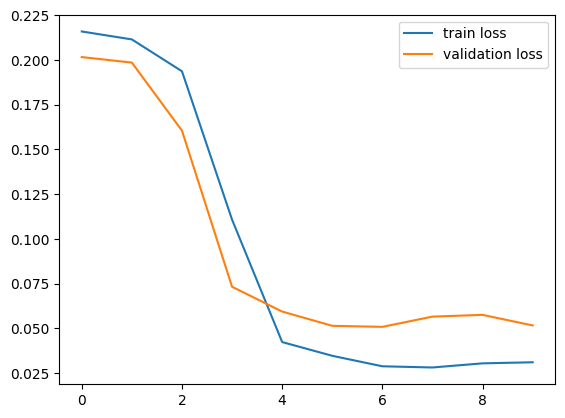

In [143]:
mode = "train"
if (mode == "train"):
    hist = model_40.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[saver])
    show_results(hist)
else:
    model_40 = load_model("CNNSheeps4_10")

Lets see predicted values and real

In [144]:
model_40.predict(np.array([X_test[0]]))[0].reshape(6, 4)

1/1 [==============================] - 0s 83ms/step


array([[2.90550143e-01, 8.11652541e-01, 1.59414873e-01, 8.77198279e-01],
       [9.31317806e-02, 1.99163303e-01, 5.95898554e-02, 2.51358122e-01],
       [1.04862496e-01, 1.73356023e-03, 4.74864841e-02, 6.12227470e-02],
       [3.12652141e-02, 4.92111668e-02, 2.23346855e-02, 3.85800377e-02],
       [3.82332243e-02, 8.15325999e-04, 2.12317146e-02, 2.70997286e-02],
       [2.23121550e-02, 7.78645417e-03, 4.10289504e-02, 1.32905247e-04]],
      dtype=float32)

In [145]:
y_test[0].reshape(6, 4)

array([[0.05882353, 0.93048128, 0.1037037 , 0.86666667],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])

Lets delete inadequate boxes and see results:

In [148]:
def processs_results(r=0):
    predicted = model_40.predict(np.array([X_test[r]]))[0].reshape(6, 4)
    real = y_test[r].reshape(6, 4)
    processed_box = []
    real_box = []
    for i in range(6):
        coords = [min(272, int(i*273)) for i in predicted[i]]
        if (abs(coords[0]-coords[1]) < 5 or abs(coords[2]-coords[3]) < 5):
            continue
        if (coords[0] > coords[1] or coords[2] > coords[3]):
            continue
        processed_box.append(coords)
        coords = [int(i*273) for i in real[i]]
        if (abs(coords[0]-coords[1]) < 5 or abs(coords[2]-coords[3]) < 5):
            continue
        if (coords[0] > coords[1] or coords[2] > coords[3]):
            continue
        real_box.append(coords)
    return sorted(processed_box), sorted(real_box)
for j in range(len(X_test)):
    a, b = processs_results(j)
    print("Predicted box: ", a)
    print("Real box: ", b)

1/1 [==============================] - 0s 29ms/step
Predicted box:  [[25, 54, 16, 68], [79, 221, 43, 239]]
Real box:  [[16, 254, 28, 236]]
1/1 [==============================] - 0s 29ms/step
Predicted box:  [[53, 87, 15, 55], [120, 225, 59, 225]]
Real box:  [[0, 146, 4, 270], [128, 273, 2, 271]]
1/1 [==============================] - 0s 31ms/step
Predicted box:  [[27, 66, 15, 58], [84, 214, 40, 229]]
Real box:  [[6, 266, 30, 257]]
1/1 [==============================] - 0s 32ms/step
Predicted box:  [[119, 226, 69, 256]]
Real box:  [[21, 167, 73, 243]]
1/1 [==============================] - 0s 30ms/step
Predicted box:  [[35, 60, 22, 84], [96, 213, 39, 213]]
Real box:  [[0, 272, 13, 254]]
1/1 [==============================] - 0s 32ms/step
Predicted box:  [[34, 56, 35, 77], [103, 216, 65, 242]]
Real box:  [[49, 273, 69, 273]]
1/1 [==============================] - 0s 39ms/step
Predicted box:  [[29, 59, 18, 81], [64, 206, 56, 215]]
Real box:  [[34, 214, 14, 264]]
1/1 [=====================

Prepare images with boxes. 

In [149]:
def show_image_result(test_num):
    processed_box, real_box = processs_results(r=test_num)
    print(processed_box, real_box)
    img = X_test[test_num].copy()
    for coords1 in processed_box:
        img = cv2.rectangle(img, (coords1[0], coords1[2]), (coords1[1], coords1[3]), ( 255, 0, 0 ), 3)
    for coords1 in real_box:
        img = cv2.rectangle(img, (coords1[0], coords1[2]), (coords1[1], coords1[3]), ( 0, 255, 255 ), 3)
    cv2.imshow("wret", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

To show result of execution choose number of image and run cell

In [152]:
t = 12
show_image_result(t)

1/1 [==============================] - 0s 45ms/step
[[49, 92, 22, 74], [98, 217, 43, 213]] [[85, 234, 59, 247]]


In [155]:
c = 0
for i in range(len(X_test)):
    processed_box, real_box = processs_results(i)
    c += abs(len(processed_box)-len(real_box))
count_difference = c
count_difference

1/1 [==============================] - 0s 33ms/step


12

In [171]:
def sq_inter(boxa, boxb):
    a = max(0, min(boxa[1], boxb[1])-max(boxa[0], boxb[0]))
    b = max(0, min(boxa[3], boxb[3])-max(boxa[2], boxb[2]))
    return a*b

def sq_outer(boxa, boxb):
    a = (boxa[1]-boxa[0])*(boxa[3]-boxa[2])
    b = (boxb[1]-boxb[0])*(boxb[3]-boxb[2])
    i = sq_inter(boxa, boxb)
    return a+b-i

def iou(boxa, boxb):
    out = sq_outer(boxa, boxb)
    ini = sq_inter(boxa, boxb)
    if (out == 0):
        return -1
    return ini/out

c = 0
mc = []
m50 = 0
probs = []
for i in range(len(X_test)):
    print("IMAGE ", i)
    processed_box, real_box = processs_results(i)
    metricses = []
    for pred in processed_box:
        ms = []
        for real in real_box:
            metric = iou(pred, real)
            ms.append(metric)
        metricses.append(max(ms))
        if (max(ms) > 0.5):
            m50 +=1
        c+=1
        mc.append(max(ms))
    print(metricses)
    s = sum(metricses)
    probs_iou = [t/s for t in metricses]
    probs.append(max(probs_iou))

print("AVERAGE IoU ", sum(mc)/c)
print("BOX with 50% accuracy ", m50)
print("Confidence level ", sum(probs)/17)

IMAGE  0
1/1 [==============================] - 0s 37ms/step
[0.023268875872582844, 0.5488884438213499]
IMAGE  1
1/1 [==============================] - 0s 35ms/step
[0.03501905448552889, 0.39922643988793294]
IMAGE  2
1/1 [==============================] - 0s 36ms/step
[0.0183206106870229, 0.41629955947136565]
IMAGE  3
1/1 [==============================] - 0s 33ms/step
[0.22253129346314326]
IMAGE  4
1/1 [==============================] - 0s 37ms/step
[0.023645350256285086, 0.3105626067854528]
IMAGE  5
1/1 [==============================] - 0s 33ms/step
[0.0012026458208057728, 0.42361532460778367]
IMAGE  6
1/1 [==============================] - 0s 32ms/step
[0.03475670307845084, 0.5017333333333334]
IMAGE  7
1/1 [==============================] - 0s 35ms/step
[0.0, 0.29588282200864563]
IMAGE  8
1/1 [==============================] - 0s 35ms/step
[0.010254106525518076, 0.5301384578658391]
IMAGE  9
1/1 [==============================] - 0s 35ms/step
[0.013905683192261185, 0.253015044137759

As we see, our model returns 2 boxes from left border and the second is slighly similar to target.

Overall results of model (CD - count difference):

MSE: 0.0517

CD: 12

avg IoU: 0.223

boxes with ioU > 50% : 5 from 17 images

Confidence level for iamges with one sheep: 0.97


## Masking

In this approach I use 273x273 masking matrix, where value 1 if sheep in the pixel and 0 else.

Extract masks

In [ ]:
y = []
for sheep in sheeps:
    for b in sheep["objects"]:
        mask = np.zeros((273, 273))
        b = [min(273, int(i)) for i in np.array(b)*273]
        for x in range(b[0], b[1]):
            for t in range(b[2], b[3]):
                mask[t][x] = 1
    y.append(mask)
y = np.array(y)
y.shape

(203, 273, 273)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

Build model with upsampling

In [ ]:
from keras.layers import UpSampling2D, Resizing

In [ ]:
model = Sequential()
model.add(Input((273, 273, 3)))
model.add(Conv2D(3, (8, 8), activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(3, (8, 8), activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(3, (8, 8), activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(3, (8, 8), activation="relu"))
model.add(Conv2D(3, (8, 8), activation="relu"))
model.add(Dropout(0.25))
model.add(Conv2D(3, (3, 3), (1, 1), activation="relu"))
model.add(Dropout(0.25))
model.add(Conv2D(1, (2, 2), (1, 1), activation="sigmoid"))
model.add(UpSampling2D((8, 8)))
model.add(Resizing(273, 273))
saver = ModelCheckpoint("CNNSheepsMASK")
model.compile(loss="mse")
model.summary()


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_130 (Conv2D)         (None, 266, 266, 3)       579       
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 133, 133, 3)      0         
 g2D)                                                            
                                                                 
 conv2d_131 (Conv2D)         (None, 126, 126, 3)       579       
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 63, 63, 3)        0         
 g2D)                                                            
                                                                 
 conv2d_132 (Conv2D)         (None, 56, 56, 3)         579       
                                                                 
 max_pooling2d_71 (MaxPoolin  (None, 28, 28, 3)      

Epoch 1/10
5/5 [==============================] - ETA: 0s - loss: 0.2418

INFO:tensorflow:Assets written to: CNNSheepsMASK\assets


INFO:tensorflow:Assets written to: CNNSheepsMASK\assets


5/5 [==============================] - 6s 1s/step - loss: 0.2418 - val_loss: 0.2213
Epoch 2/10
5/5 [==============================] - ETA: 0s - loss: 0.2521

INFO:tensorflow:Assets written to: CNNSheepsMASK\assets


INFO:tensorflow:Assets written to: CNNSheepsMASK\assets


5/5 [==============================] - 8s 2s/step - loss: 0.2521 - val_loss: 0.2257
Epoch 3/10
5/5 [==============================] - ETA: 0s - loss: 0.2389

INFO:tensorflow:Assets written to: CNNSheepsMASK\assets


INFO:tensorflow:Assets written to: CNNSheepsMASK\assets


5/5 [==============================] - 8s 2s/step - loss: 0.2389 - val_loss: 0.2161
Epoch 4/10
5/5 [==============================] - ETA: 0s - loss: 0.2370

INFO:tensorflow:Assets written to: CNNSheepsMASK\assets


INFO:tensorflow:Assets written to: CNNSheepsMASK\assets


5/5 [==============================] - 9s 2s/step - loss: 0.2370 - val_loss: 0.2331
Epoch 5/10
5/5 [==============================] - ETA: 0s - loss: 0.2374

INFO:tensorflow:Assets written to: CNNSheepsMASK\assets


INFO:tensorflow:Assets written to: CNNSheepsMASK\assets


5/5 [==============================] - 9s 2s/step - loss: 0.2374 - val_loss: 0.2221
Epoch 6/10
5/5 [==============================] - ETA: 0s - loss: 0.2350

INFO:tensorflow:Assets written to: CNNSheepsMASK\assets


INFO:tensorflow:Assets written to: CNNSheepsMASK\assets


5/5 [==============================] - 9s 2s/step - loss: 0.2350 - val_loss: 0.2063
Epoch 7/10
5/5 [==============================] - ETA: 0s - loss: 0.2342

INFO:tensorflow:Assets written to: CNNSheepsMASK\assets


INFO:tensorflow:Assets written to: CNNSheepsMASK\assets


5/5 [==============================] - 9s 2s/step - loss: 0.2342 - val_loss: 0.2074
Epoch 8/10
5/5 [==============================] - ETA: 0s - loss: 0.2320

INFO:tensorflow:Assets written to: CNNSheepsMASK\assets


INFO:tensorflow:Assets written to: CNNSheepsMASK\assets


5/5 [==============================] - 9s 2s/step - loss: 0.2320 - val_loss: 0.2283
Epoch 9/10
5/5 [==============================] - ETA: 0s - loss: 0.2308

INFO:tensorflow:Assets written to: CNNSheepsMASK\assets


INFO:tensorflow:Assets written to: CNNSheepsMASK\assets


5/5 [==============================] - 9s 2s/step - loss: 0.2308 - val_loss: 0.2015
Epoch 10/10
5/5 [==============================] - ETA: 0s - loss: 0.2342

INFO:tensorflow:Assets written to: CNNSheepsMASK\assets


INFO:tensorflow:Assets written to: CNNSheepsMASK\assets


5/5 [==============================] - 9s 2s/step - loss: 0.2342 - val_loss: 0.2203


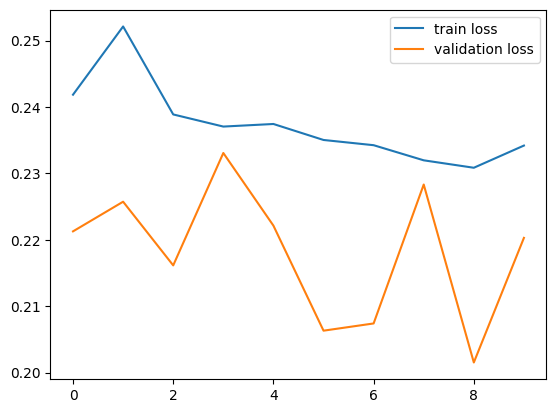

In [ ]:
mode="train"
if (mode=="train"):
    hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[saver])
    show_results(hist)
else:
    model = load_model("CNNSheepsMASK")

In [ ]:
tt = model.predict(np.array([X_test[0]]))[0]
tt

1/1 [==============================] - 0s 80ms/step


array([[[0.44949976],
        [0.44949976],
        [0.44949976],
        ...,
        [0.44958174],
        [0.44958174],
        [0.44958174]],

       [[0.44949976],
        [0.44949976],
        [0.44949976],
        ...,
        [0.44958174],
        [0.44958174],
        [0.44958174]],

       [[0.44949976],
        [0.44949976],
        [0.44949976],
        ...,
        [0.44958174],
        [0.44958174],
        [0.44958174]],

       ...,

       [[0.4469844 ],
        [0.4469844 ],
        [0.4469844 ],
        ...,
        [0.46360114],
        [0.46360114],
        [0.46360114]],

       [[0.4469844 ],
        [0.4469844 ],
        [0.4469844 ],
        ...,
        [0.46360114],
        [0.46360114],
        [0.46360114]],

       [[0.4469844 ],
        [0.4469844 ],
        [0.4469844 ],
        ...,
        [0.46360114],
        [0.46360114],
        [0.46360114]]], dtype=float32)

In [ ]:
def processs_results_mask(r=0):
    predicted = model.predict(np.array([X_test[r]]))[0]
    real = y_test[r]
    processed_box = []
    real_box = []
    for i in range(10):
        coords = [min(272, int(i*273)) for i in predicted[i]]
        if (abs(coords[0]-coords[1]) < 5 or abs(coords[2]-coords[3]) < 5):
            continue
        if (coords[0] > coords[1] or coords[2] > coords[3]):
            continue
        processed_box.append(coords)
        coords = [int(i*273) for i in real[i]]
        if (abs(coords[0]-coords[1]) < 5 or abs(coords[2]-coords[3]) < 5):
            continue
        if (coords[0] > coords[1] or coords[2] > coords[3]):
            continue
        real_box.append(coords)
    return sorted(processed_box), sorted(real_box)
for j in range(len(X_test)):
    pass
    #print(processs_results(j))

Use (i - min)/(max-min) to show probability level for pixel groups.

Write number of picture in t and run cell to see prediction

In [ ]:
t = 9
y_pred = model.predict(np.array([X_test[t]]))[0]
s = list(y_pred.reshape(273*273))
ms = max(s)
ls = min(s)
s = [(i-ls)/(ms-ls) for i in s]
y_mask = np.array(s).reshape(273, 273, 1)
y_real = y_test[t].reshape(273, 273, 1)
if (1):
    cv2.imshow("real", X_test[t])
    cv2.imshow("mask", y_real)
    cv2.imshow("predicted", y_mask)
    cv2.waitKey(0)


1/1 [==============================] - 0s 24ms/step


Results: 

MSE: 0.2203

## Conclusion

In this project I have tried two base algorithms on CNN - regression of bounding box coordinates and prediction of areas of pixels corrsponding to target object - sheep.
First model can predict one sheep with average IoU 0.22.
Next model can approximately predict areas with MSE metric 0.22
Used dataset from Kaggle 